# Import Library

In [2]:

from cartopy import config
import cartopy
import cartopy.crs as ccrs
import climtas
import cmocean
from collections import namedtuple
import dask.array
from datetime import datetime
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import scipy.stats
from scipy import stats
from scipy.stats import ttest_ind 
import seaborn as sns
import sparse
from string import ascii_lowercase
import xarray as xr


import warnings
warnings.filterwarnings("ignore")
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr    
import glob
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors
import pandas as pd
import datetime
from matplotlib import colors
import pymannkendall as mk
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [3]:
cmap2 = plt.cm.get_cmap("plasma_r", 15)

# Read DMI files

In [4]:
#DMI
d_filenames = sorted(glob.glob("/g/data/w97/sl7808/ALLOUTPUT/DMI_ACCESS/*.nc")) 

file_name = []
f=[]
for d in d_filenames:   
    
    a = xr.open_dataset(d)
    DMI_p=a.sel(time=a.time.dt.month.isin([8,9,10])) #select DMI peak months
    x=DMI_p.tos.groupby('time.year').mean(dim='time')#take the mean of each year
    z=x.rename({'year':'time'})
    del z['time']
    f.insert(-1,z)

pIOD_1=xr.concat(f, 'ensemble').isel(time=slice(0,164))
pIOD=pIOD_1

# Figure 4-7

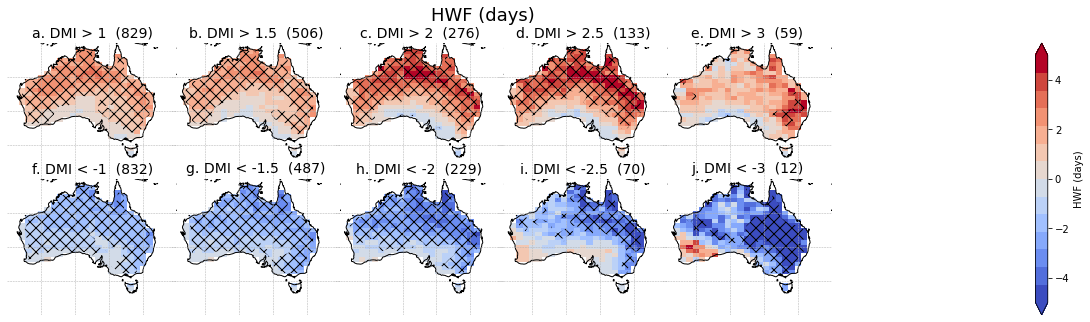

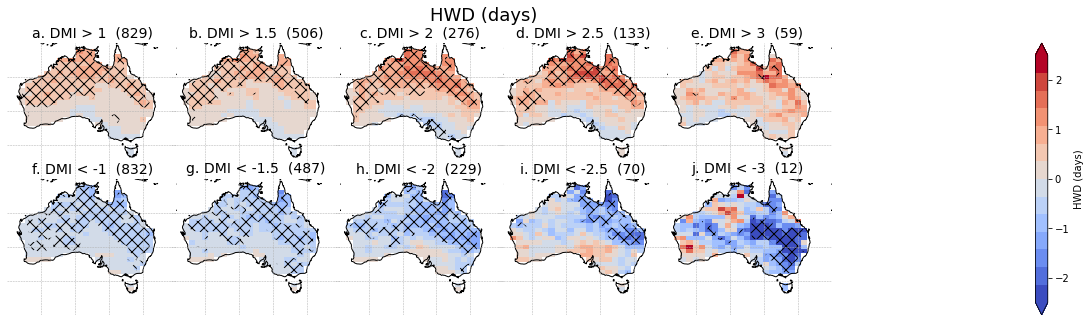

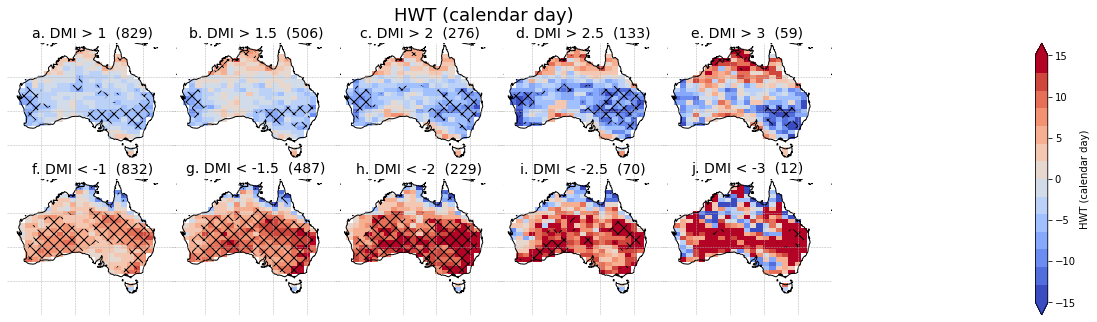

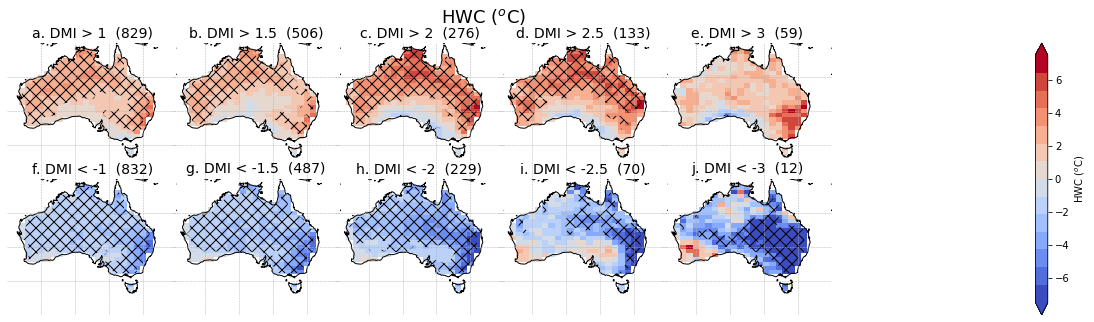

In [29]:
HWX_list =["HWF_EHF","HWD_EHF","HWT_EHF","HWC"]
HWX_list_2 =["HWF (days)","HWD (days)","HWT (calendar day)",'HWC ($^o$C)']

vmaxlist=[17.5,9,80,25]
vminlist=[5,3,40,5]
vmaxlist2=[5,2.5,15,7.5]
vminlist2=[-5,-2.5,-15,-7.5]
abc=["a","b","c","d"]



land_sea = xr.open_dataset("/g/data/w97/sl7808/landmask_accessESM1-5_AUS.nc").sftlf



for (h,xxx,nnn,xxx2,nnn2,aaa,h2) in zip (HWX_list,vmaxlist,vminlist,vmaxlist2,vminlist2,abc,HWX_list_2):
    #HWX
    abc=0
    fig, axes = plt.subplots(2,6, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    


    for i in range(5):
        for j in range(2):
            axes[j,i].gridlines(ylocs=[-10,-20,-30,-40],draw_labels=False,
                       linewidth=0.5, linestyle='--', edgecolor='dimgrey')
            axes[j,i].axis('off')         
            axes[j,5].axis('off')         

    
    

    d = ("/g/data/w97/sl7808/ALLOUTPUT/EHF_year_ACCESS/by_HWX/"+h+".nc") 
    d1=xr.open_dataset(d, decode_times=False)
    HWA=d1[h]


    # plot
    
    
    list2=[0,1,2,3,4]
    plist=[1,1.5,2,2.5,3]
    nlist=[-1,-1.5,-2,-2.5,-3]
    
    
    num=1
    
    #neutral
    g_neu=[]
    ggg_neu=[]
    c_neu1=0
    for i in range(20): 
        pIOD_sel=pIOD.isel(ensemble=i)
        H1=HWA.isel(ensemble=i).where(land_sea>60)
        H3=H1.where(pIOD_sel<=1).where(pIOD_sel>=-1)
        g_neu.insert(-1,H3)


        ccc=H3.dropna(dim='time',how='all').time.count()
        c_neu1=c_neu1+ccc

    ggg_neu=xr.concat(g_neu, 'ensemble')  
    ggg_neu_mean=ggg_neu.mean(dim=['ensemble','time'])
    ggg_neu_stacked = ggg_neu.stack(ens_time=['time','ensemble'])


    
    for p,l2,n in zip (plist,list2,nlist):
        

        
        
        #positive
        g_pos=[]
        ggg_pos=[]
        c_pos1=0
        for i in range(20): 
            pIOD_sel=pIOD.isel(ensemble=i)
            H1=HWA.isel(ensemble=i).where(land_sea>60)
            H3=H1.where(pIOD_sel>p)
            g_pos.insert(-1,H3)
            
            ccc=H3.dropna(dim='time',how='all').time.count()
            c_pos1=c_pos1+ccc
            
        ggg_pos=xr.concat(g_pos, 'ensemble') 
        

        
        
        #negative
        g_neg=[]
        ggg_neg=[]
        c_neg1=0
        for i in range(20):
            pIOD_sel=pIOD.isel(ensemble=i)
            H1=HWA.isel(ensemble=i).where(land_sea>60)
            H3=H1.where(pIOD_sel<n)

            g_neg.insert(-1,H3)
            
            ccc=H3.dropna(dim='time',how='all').time.count()
            c_neg1=c_neg1+ccc
            
            
            
        ggg_neg=xr.concat(g_neg, 'ensemble')  


        
        
        
        #t-test
        
        ggg_pos_stacked = ggg_pos.stack(ens_time=['time','ensemble'])
        ggg_neg_stacked = ggg_neg.stack(ens_time=['time','ensemble'])
        
        
        r_pos = stats.ttest_ind(ggg_pos_stacked, ggg_neu_stacked, axis=2, equal_var=False, nan_policy='omit')
        p_value_pos = xr.DataArray(r_pos[1], dims=('lat', 'lon'), 
                          coords={'lat': ggg_pos['lat'],'lon': ggg_pos['lon']})
        

        r_neg = stats.ttest_ind(ggg_neg_stacked, ggg_neu_stacked, axis=2, equal_var=False, nan_policy='omit')
        p_value_neg = xr.DataArray(r_neg[1], dims=('lat', 'lon'), 
                          coords={'lat': ggg_pos['lat'],'lon': ggg_pos['lon']})        
        
        
        #plot
        cmap4=plt.cm.get_cmap("coolwarm", 14)
        
        ggg_pos_mean=ggg_pos.mean(dim=['ensemble','time'])
        ggg_pos_diff=ggg_pos_mean-ggg_neu_mean
        ggg_pos_diff.plot(ax=axes[0,l2],vmax=xxx2,vmin=nnn2,cmap=cmap4, add_colorbar=False, transform=ccrs.PlateCarree())
        p_value_pos.plot.contourf(ax=axes[0,l2],levels=[0.00, 0.05], hatches=['xx', None], colors='none', add_colorbar=False) 
        axes[0,l2].set_title(ascii_lowercase[abc]+'. DMI > '+ str(p)+'  ('+str(c_pos1.values)+')', fontsize=14)
        
        
        abc2=abc+5
        
        ggg_neg_mean=ggg_neg.mean(dim=['ensemble','time'])
        ggg_neg_diff=ggg_neg_mean-ggg_neu_mean
        gplot=ggg_neg_diff.plot(ax=axes[1,l2],vmax=xxx2,vmin=nnn2,cmap=cmap4, add_colorbar=False, transform=ccrs.PlateCarree())
        p_value_neg.plot.contourf(ax=axes[1,l2],levels=[0.00, 0.05], hatches=['xx', None], colors='none', add_colorbar=False) 
        axes[1,l2].set_title(ascii_lowercase[abc2]+'. DMI < '+ str(n)+'  ('+str(c_neg1.values)+')', fontsize=14)
        
        abc=abc+1
        
        jjlist=[0,1]
        for j in jjlist:
            axes[j,l2].coastlines()
            axes[j,l2].set_ylim([-50, -10])
            axes[j,l2].set_xlim([ 110, 160])

        num=num+1
        
        
    
    fig.colorbar(gplot, ax=axes[:,5], orientation='vertical',extend='both',label=h2)

    fig.suptitle(h2 , fontsize=18)
    fig.subplots_adjust(wspace=-0.45, hspace=0)
    
   
    



# Appendix

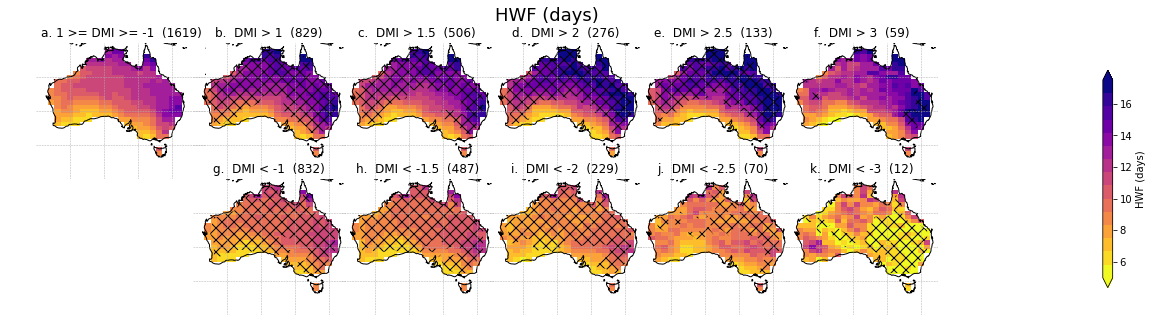

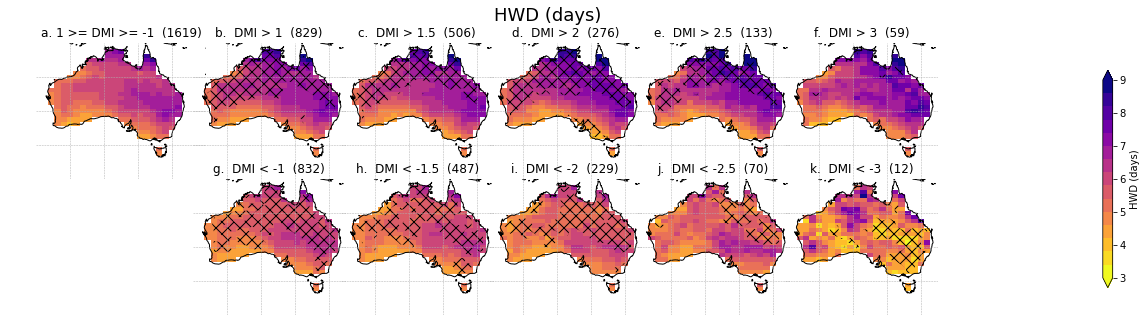

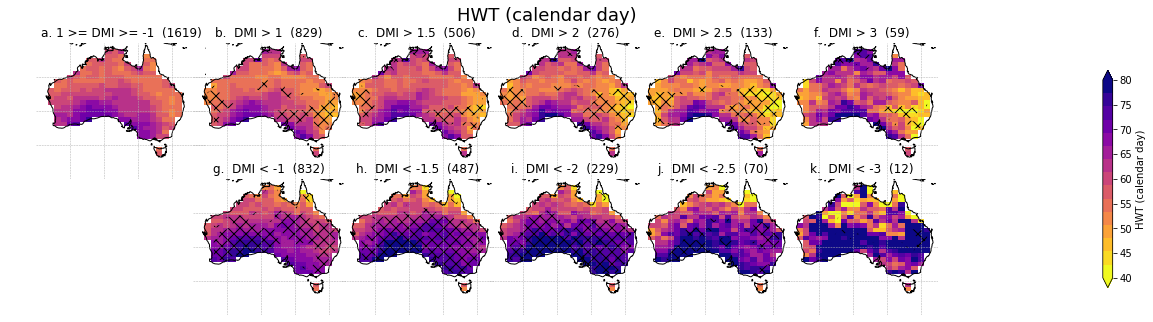

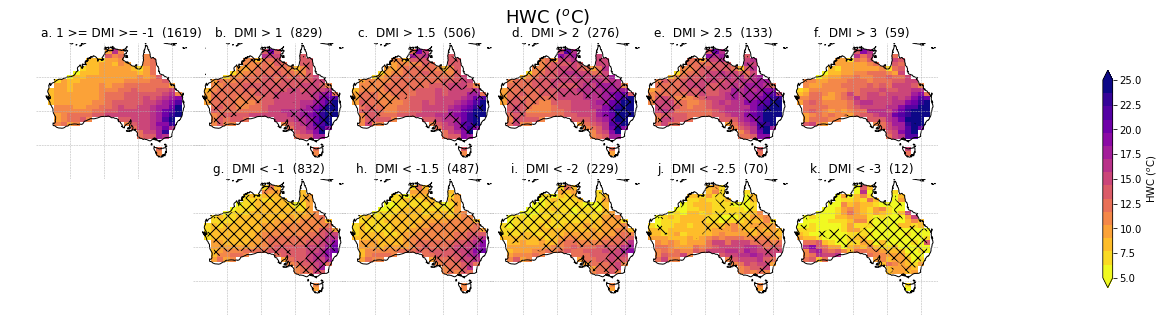

In [27]:

HWX_list =["HWF_EHF","HWD_EHF","HWT_EHF","HWC"]
HWX_list_2 =["HWF (days)","HWD (days)","HWT (calendar day)",'HWC ($^o$C)']

vmaxlist=[17.5,9,80,25]
vminlist=[5,3,40,5]



land_sea = xr.open_dataset("/g/data/w97/sl7808/landmask_accessESM1-5_AUS.nc").sftlf



for (h,xxx,nnn,h2) in zip (HWX_list,vmaxlist,vminlist,HWX_list_2):
    #HWX

    fig, axes = plt.subplots(2,7, figsize=(20,5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})
    


    for i in range(1,6):
        for j in range(2):
            axes[j,i].axis('off')         
            axes[j,i].gridlines(ylocs=[-10,-20,-30,-40],draw_labels=False,
                       linewidth=0.5, linestyle='--', edgecolor='dimgrey')
            axes[j,6].axis('off') 
            axes[j,0].axis('off') 

    
    

    d = ("/g/data/w97/sl7808/ALLOUTPUT/EHF_year_ACCESS/by_HWX/"+h+".nc") 
    d1=xr.open_dataset(d, decode_times=False)
    HWA=d1[h]
    axes[0,0].gridlines(ylocs=[-10,-20,-30,-40],draw_labels=False,
                       linewidth=0.5, linestyle='--', edgecolor='dimgrey')

    # plot
    
    
    list2=[1,2,3,4,5,6,7]
    plist=[1,1.5,2,2.5,3]
    nlist=[-1,-1.5,-2,-2.5,-3]
    llist=["b","c","d","e","f"]
    llist2=["g","h","i","j","k"]
    
    
    num=1
    
    #neutral
    g_neu=[]
    ggg_neu=[]
    c_neu1=0
    for i in range(20): 
        pIOD_sel=pIOD.isel(ensemble=i)
        H1=HWA.isel(ensemble=i).where(land_sea>60)
        H3=H1.where(pIOD_sel<=1).where(pIOD_sel>=-1)
        g_neu.insert(-1,H3)


        ccc=H3.dropna(dim='time',how='all').time.count()
        c_neu1=c_neu1+ccc

    ggg_neu=xr.concat(g_neu, 'ensemble')  
    ggg_neu.mean(dim=['ensemble','time']).plot(ax=axes[0,0],vmax=xxx,vmin=nnn,cmap=cmap2, add_colorbar=False, transform=ccrs.PlateCarree())
    ggg_neu_stacked = ggg_neu.stack(ens_time=['time','ensemble'])

    axes[0,0].set_title('a. 1 >= DMI >= -1'+'  ('+str(c_neu1.values)+')', fontsize=12)
    axes[0,0].coastlines()
    axes[0,0].set_ylim([-50, -10])
    axes[0,0].set_xlim([ 110, 160])

    
    
    for p,l2,n,lll,lll2 in zip (plist,list2,nlist,llist,llist2):

        
        #positive
        g_pos=[]
        ggg_pos=[]
        c_pos1=0
        for i in range(20): 
            pIOD_sel=pIOD.isel(ensemble=i)
            H1=HWA.isel(ensemble=i).where(land_sea>60)
            H3=H1.where(pIOD_sel>p)
            g_pos.insert(-1,H3)
            
            ccc=H3.dropna(dim='time',how='all').time.count()
            c_pos1=c_pos1+ccc
            
        ggg_pos=xr.concat(g_pos, 'ensemble') 


        
        
        

        
        
        #negative
        g_neg=[]
        ggg_neg=[]
        c_neg1=0
        for i in range(20):
            pIOD_sel=pIOD.isel(ensemble=i)
            H1=HWA.isel(ensemble=i).where(land_sea>60)
            H3=H1.where(pIOD_sel<n)
            g_neg.insert(-1,H3)
            
            ccc=H3.dropna(dim='time',how='all').time.count()
            c_neg1=c_neg1+ccc
            
            
            
        ggg_neg=xr.concat(g_neg, 'ensemble')  

        
        
        
        #t-test
        
        ggg_pos_stacked = ggg_pos.stack(ens_time=['time','ensemble'])
        ggg_neg_stacked = ggg_neg.stack(ens_time=['time','ensemble'])
        
        
        r_pos = stats.ttest_ind(ggg_pos_stacked, ggg_neu_stacked, axis=2, equal_var=False, nan_policy='omit')
        p_value_pos = xr.DataArray(r_pos[1], dims=('lat', 'lon'), 
                          coords={'lat': ggg_pos['lat'],'lon': ggg_pos['lon']})
        

        r_neg = stats.ttest_ind(ggg_neg_stacked, ggg_neu_stacked, axis=2, equal_var=False, nan_policy='omit')
        p_value_neg = xr.DataArray(r_neg[1], dims=('lat', 'lon'), 
                          coords={'lat': ggg_pos['lat'],'lon': ggg_pos['lon']})        
        
        
        #plot
        
        
        ggg_pos.mean(dim=['ensemble','time']).plot(ax=axes[0,l2],vmax=xxx,vmin=nnn,cmap=cmap2, add_colorbar=False, transform=ccrs.PlateCarree())
        p_value_pos.plot.contourf(ax=axes[0,l2],levels=[0.00, 0.05], hatches=['xx', None], colors='none', add_colorbar=False, transform=ccrs.PlateCarree()) 
        axes[0,l2].set_title(lll+'.  DMI > '+ str(p)+'  ('+str(c_pos1.values)+')', fontsize=12)
        
        
        plott=ggg_neg.mean(dim=['ensemble','time']).plot(ax=axes[1,l2],vmax=xxx,vmin=nnn,cmap=cmap2, add_colorbar=False, transform=ccrs.PlateCarree())
        p_value_neg.plot.contourf(ax=axes[1,l2],levels=[0.00, 0.05], hatches=['xx', None], colors='none', add_colorbar=False, transform=ccrs.PlateCarree()) 
        axes[1,l2].set_title(lll2+'.  DMI < '+ str(n)+'  ('+str(c_neg1.values)+')', fontsize=12)
        
        
        jjlist=[0,1]
        for j in jjlist:
            axes[j,l2].coastlines()
            axes[j,l2].set_ylim([-50, -10])
            axes[j,l2].set_xlim([ 110, 155])

        num=num+1
        


    
    
    fig.colorbar(plott, ax=axes[:,6], orientation='vertical',extend='both',label=h2,shrink=0.8)
    fig.suptitle(h2, fontsize=18)
    fig.subplots_adjust(wspace=-0.35, hspace=0)
    


# Appendix

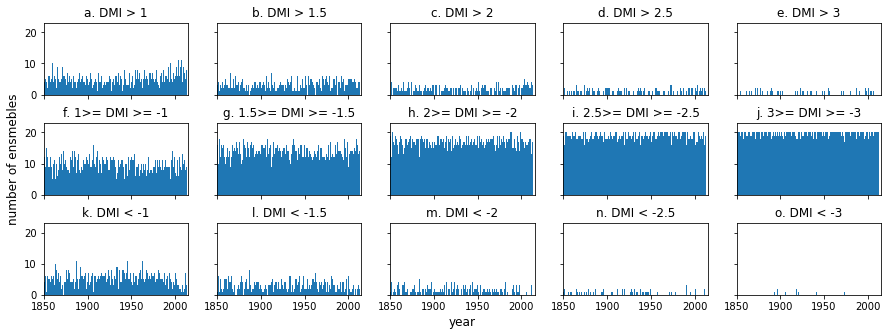

In [28]:

h="HWA_EHF"

land_sea = xr.open_dataset("/g/data/w97/sl7808/landmask_accessESM1-5_AUS.nc").sftlf




fig, axes = plt.subplots(3,5, figsize=(15,5), sharey=True, sharex=True)




d = ("/g/data/w97/sl7808/ALLOUTPUT/EHF_year_ACCESS/by_HWX/"+h+".nc") 
d1=xr.open_dataset(d, decode_times=False)
HWA=d1


# plot


list2=[0,1,2,3,4,5,6]
plist=[1,1.5,2,2.5,3]
nlist=[-1,-1.5,-2,-2.5,-3]


num=1
abc_0=0
for p,l2,n in zip (plist,list2,nlist):

    #print(p)


    #neutral
    g_neu=[]
    ggg_neu=[]
    c_neu1=0
    for i in range(20): 
        pIOD_sel=pIOD.isel(ensemble=i)
        H1=HWA.isel(ensemble=i).where(land_sea>60)
        H3=H1.where(pIOD_sel<=p).where(pIOD_sel>=n)

        ccc=H3.dropna(dim='time',how='all').time
        g_neu.insert(-1,ccc)


    ggg_neu=xr.concat(g_neu, dim='t')  
    ggg_neu.plot.hist(ax=axes[1,l2],bins=164)
    axes[1,l2].set_xlim([1850, 2015])
    axes[1,l2].set_ylim([0, 23])
    abc_1=abc_0+5
    axes[1,l2].set_title(ascii_lowercase[abc_1]+". "+str(p)+'>= DMI >= '+ str(n), fontsize=12)


    #positive
    g_pos=[]
    ggg_pos=[]
    c_pos1=0
    for i in range(20): 
        pIOD_sel=pIOD.isel(ensemble=i)
        H1=HWA.isel(ensemble=i).where(land_sea>60)
        H3=H1.where(pIOD_sel>p)

        ccc=H3.dropna(dim='time',how='all').time
        g_pos.insert(-1,ccc)


    ggg_pos=xr.concat(g_pos, dim='t')  
    ggg_pos.plot.hist(ax=axes[0,l2],bins=164)
    axes[0,l2].set_xlim([1850, 2015])
    axes[0,l2].set_ylim([0, 23])







    #negative
    g_neg=[]
    ggg_neg=[]
    c_neg1=0
    for i in range(20):
        pIOD_sel=pIOD.isel(ensemble=i)
        H1=HWA.isel(ensemble=i).where(land_sea>60)
        H3=H1.where(pIOD_sel<n)   

        ccc=H3.dropna(dim='time',how='all').time
        g_neg.insert(-1,ccc)


    ggg_neg=xr.concat(g_neg, dim='t')  
    ggg_neg.plot.hist(ax=axes[2,l2],bins=164)
    axes[2,l2].set_xlim([1850, 2015])
    axes[2,l2].set_ylim([0, 23])
    axes[2,l2].set_xlabel('', fontsize=8)
    
    axes[2,2].set_xlabel('year', fontsize=12)


    axes[0,l2].set_xlabel('', fontsize=8)
    axes[1,l2].set_xlabel('', fontsize=8)
    axes[1,0].set_ylabel('number of ensmebles', fontsize=12)
    axes[0,l2].set_title(ascii_lowercase[abc_0]+'. DMI > '+ str(p), fontsize=12)

    abc_2=abc_0+10
    axes[2,l2].set_title(ascii_lowercase[abc_2]+'. DMI < '+ str(n), fontsize=12)
    
    abc_0=abc_0+1

fig.subplots_adjust(wspace=0.2, hspace=0.4)



